## Cosas ha hacer: ##
1. Integracion: 
    - Obtención de datos: OK
    - Explicación del dataset: OK
    - Resolver duplicidades e incosistencias. OK 
    - Resolver problemas de codificacion (unidades de medida Km, m). OK
2. Preprocesamiento:
    - Outliers: OK.
    - Valores faltantes: OK.
    - Normalizar: OK
    - Discr etizar
    - Selección/Reducción de variables.
3. Modelo: (Conjunto Entrenamiento, Test y Validación)
    - KNN.
    - RegresOKión lógistica. (Filtros ruido TOMEK LINKS, CVCF)
    - Arboles OK pero sin filtros.
4. Evalución:  OKMetodologias dividir datos entrenamiento, validacion y test
    - Matriz de confusión. OK
    - Clasificacion precision predictiva(Usando Grid).
    - Error cuadratico medio.
5. Interpretación y difusión:
    - Usos del modelo.



## Proyecto Final
- Yeray Aller Errea
- Javier Aranguren Ortiz
### Resumen
El objetivo de nuestro grupo va a ser utilizar las distintas herramientas que nos proporciona esta asignatura para identificar que tipo de trigo es.

### Desarrollo
![Descripción KDD](KDD.jpg)  
Para este proyeto vamos a utilizar la metodología KDD, que se divide en la siguientes etapas
1. Integracion y recopilacion.
2. Preprocesamiento.
3. Modelado.
4. Evalución.
5. Disfusiónn.


## INTEGRACIÓN Y RECOPILACIÓN ##
### Dataset ###
Para ese proyecto hemos seleccionado el dataset [Seeds](https://www.kaggle.com/datasets/rwzhang/seeds-dataset).El conjunto de datos Seeds contiene siete atributos geométricos de granos de trigo, y hay tres variedades de trigo.
- Área del grano **A**
- Perímetro del grano **P**
- Compacidad del grano **C** = 4 * pi * A / P^2
- Longitud del núcleo
- Ancho del núcleo
- Coeficiente de asimetría
- Longitud del surco del núcleo

### Librerias ###
Para el siguiente proyecto hemos usado las siguientes librerias:
- Pandas: Librería que permite analizar datos y manipularlos. En nuestro caso la usamos para leer y almacenar los datos de esta práctica.
- Numpy: Librería que permite crear vectores multidimensinales y operaciones matematicas.
- Sklearn: (scikit-learn): Librería que permite analizar datos, realizar predicciones...

In [13]:
##Importamos todas las librerias necesarias para la práctica
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Carga de datos
La información necesaria para este proyecto se encuentra seed_dataset.txt, la extraemos y la almacenamos.

In [14]:
# Lectura del archivo csv
seeds = pd.read_csv('seeds_dataset.txt', delim_whitespace=True, header=None)
# Asignamos los nombres de las columnas
feature_names = ['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel', 'asymmetry_coeff', 'length_kernel_groove']
class_names = ['Kama', 'Rosa', 'Canadian']
seeds.columns = ['area', 'perimetro', 'compacidad', 'longitud_nucleo', 'ancho_nucleo', 'coeficiente_asimetria', 'longitud_surco', 'class']
seeds

,area,perimetro,compacidad,longitud_nucleo,ancho_nucleo,coeficiente_asimetria,longitud_surco,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


En primer lugar mostramos un resumen estadístico de la información de las variables del dataset.

In [15]:
print(seeds.describe())

             area   perimetro  compacidad  longitud_nucleo  ancho_nucleo  \
count  210.000000  210.000000  210.000000       210.000000    210.000000   
mean    14.847524   14.559286    0.870999         5.628533      3.258605   
std      2.909699    1.305959    0.023629         0.443063      0.377714   
min     10.590000   12.410000    0.808100         4.899000      2.630000   
25%     12.270000   13.450000    0.856900         5.262250      2.944000   
50%     14.355000   14.320000    0.873450         5.523500      3.237000   
75%     17.305000   15.715000    0.887775         5.979750      3.561750   
max     21.180000   17.250000    0.918300         6.675000      4.033000   

       coeficiente_asimetria  longitud_surco       class  
count             210.000000      210.000000  210.000000  
mean                3.700201        5.408071    2.000000  
std                 1.503557        0.491480    0.818448  
min                 0.765100        4.519000    1.000000  
25%                 

## Preprocesamiento
Consiste en revisar los datos para asegurar su calidad, para ello realizamos los siguientes pasos/funciones.

### Valores Faltantes
Comprobamos si hay alguna fila que tenga la columna class vacia y la tratamos

In [16]:
#def esValoresFaltantes(datast):
#    if()

if(seeds["class"].isnull().sum()==0):
    print("No hay clases sin valor")
else:
    print("Hay clases sin valor")
    

No hay clases sin valor


### Valores duplicados
Comprobamos si existen duplicidades o inconsistencias y las tratamos.

In [17]:
if(seeds.duplicated().any()):
    seeds.drop_duplicates()
    print("Duplicidades eliminadas")
else:
    print("No existen duplicidades")

No existen duplicidades


Generamos dos DataFrames: uno para la información de entrada (X) y otro para la de salida (y)

In [18]:
X = seeds.iloc[:, :-1]
y = seeds.iloc[:, -1]

A continuación vamos a dividir los ejemplos en train, validación y test utilizando Hold-out con estratificación y el valor 42 como semilla.

Vamos a dividir los conjuntos en un 10% test, 80% entrenamiento y el restante validacion.

In [19]:
X_resto, X_test, y_resto, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_resto, y_resto, test_size=0.2, stratify=y_resto, random_state=42)

Creamos la clase de detección y tratamiento de Outliers

In [20]:
class OutlierDetecion_treatment_IQR(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=1.5, columns=None):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
            self.stats = X.describe()
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        Xaux = X.copy()
        # Se calula el IQR de cada variable
        IQRs = self.stats.loc['75%'] - self.stats.loc['25%']
        # Se calculan los límites inferiores y superiores   
        limiteInf = self.stats.loc['25%'] - self.k * IQRs
        limiteSup = self.stats.loc['75%'] + self.k * IQRs
        # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)  
        menores = (X < limiteInf)
        mayores = (X > limiteSup)
        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        for c in self.columns:
            # obtenemos la lista de booleanos correspondientes a si los valores de los ejemplos son outliers o no para la variable c
            indices = np.logical_or(menores[c], mayores[c])
            # Si hay outliers
            if indices.any():
                # Los sustituimos por la mediana
                print(Xaux.loc[indices,c])
                Xaux.loc[indices,c] = self.stats.loc['50%',c]
        # Se devuelve el DataFrame modificado
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}

In [21]:
out_IQR = OutlierDetecion_treatment_IQR()
X_train_IQR = out_IQR.fit_transform(X_train)
if(X_train.equals(X_train_IQR)):
   print("No se han encontrado outliers")
else:
   print("Se han encontrado outliers y el dataframe ha sido modificado")
   X_train = X_train_IQR

158    0.8082
Name: compacidad, dtype: float64
207    8.315
203    8.456
Name: coeficiente_asimetria, dtype: float64
Se han encontrado outliers y el dataframe ha sido modificado


Ahora vamos a utilizar diferentes tecnicas de clasificacion para evaluar sus rendimientos.
## MODELO ##
### KNN ###

In [22]:
# Modelo
knn = KNeighborsClassifier()

# Entrenamiento
knn.fit(X_train, y_train)

# Train
prediccion_KNN_train = knn.predict(X_train)
accuracy_train = accuracy_score(y_train, prediccion_KNN_train) * 100

# Test
prediccion_KNN_test = knn.predict(X_test)
accuracy_test = accuracy_score(y_test, prediccion_KNN_test) * 100

# Resultados
print("Precisión train: {:.2f}%".format(accuracy_train))
print("Precisión test: {:.2f}%".format(accuracy_test))

Precisión train: 92.05%
Precisión test: 85.71%


In [23]:
# Usamos un grid para obtener el mejor parametro
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 1.5, 3]
}

grid_KNN = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_KNN.fit(X_train, y_train)
prediccion_KNN = grid_KNN.predict(X_test)
accuracy = accuracy_score(y_test, prediccion_KNN) * 100

print("Mejores hiperparámetros:", grid_KNN.best_params_)
print("Best score: {:.2f}%".format(grid_KNN.best_score_ * 100))
print("Precisión: {:.2f}%".format(accuracy))

Mejores hiperparámetros: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best score: 94.06%
Precisión: 85.71%


### Regresion ###

In [24]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
prediccion = lr.predict(X_test)
accuracy = accuracy_score(y_test, prediccion) * 100
print("Precisión: {:.2f}%".format(accuracy))

Precisión: 90.48%


### Arboles de decision ###

In [25]:
listaAccTrain = []
listaAccTest = []
for tipoArbol in ['gini','entropy']:
    tree = DecisionTreeClassifier(criterion=tipoArbol, random_state=123)
    tree.fit(X_train, y_train)
    prediccion_tree = tree.predict(X_train)
    accuracy = accuracy_score(y_train, prediccion_tree)
    listaAccTrain.append(accuracy * 100)
    prediccion_tree = tree.predict(X_test)
    accuracy = accuracy_score(y_test, prediccion_tree)
    listaAccTest.append(accuracy * 100)
print('Rendimiento CART en train: ', listaAccTrain[0])
print('Rendimiento CART en test: ', listaAccTest[0])
print('Rendimiento c4.5 en train: ', listaAccTrain[1])
print('Rendimiento C4.5 en test: ', listaAccTest[1])

Rendimiento CART en train:  100.0
Rendimiento CART en test:  95.23809523809523
Rendimiento c4.5 en train:  100.0
Rendimiento C4.5 en test:  95.23809523809523


Como podemos observar los arboles clasifican todos los ejemplos de entrenamiento correctamente. Esto se debe a que los arboles de decision tienden a sobre entrenar, por lo tanto pueden ser muy complicados para las características de los ejemplos de entrenamiento.
Para solucionar esto vamos utilizar tecnicas de pre-poda, de este modo obtendremos arboles mas sencillos que se ajusten mas a los datos de entrenamiento.

Para ello vamos a utilizar los híper-parámetros *min_samples_split* y *min_samples_leaf* utilizando las siguientes configuraciones:

- criterion = 'gini', min_samples_split = 2, min_samples_leaf = 1
- criterion = 'gini', min_samples_split = 6, min_samples_leaf = 3
- criterion = 'gini', min_samples_split = 10, min_samples_leaf = 5
- criterion = 'entropy', min_samples_split = 2, min_samples_leaf = 1
- criterion = 'entropy', min_samples_split = 6, min_samples_leaf = 3
- criterion = 'entropy', min_samples_split = 10, min_samples_leaf = 5

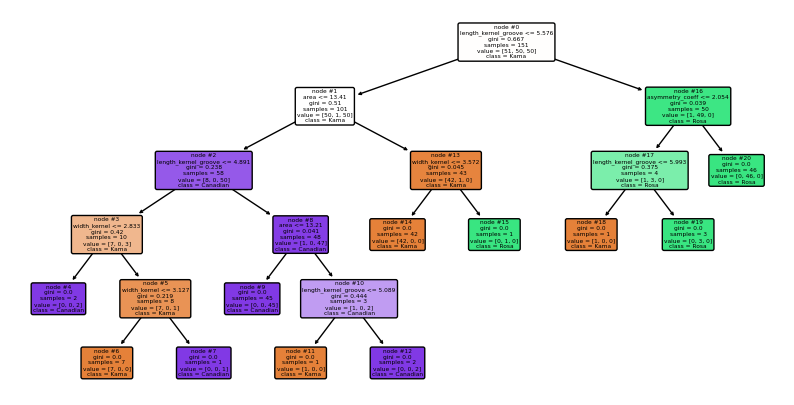

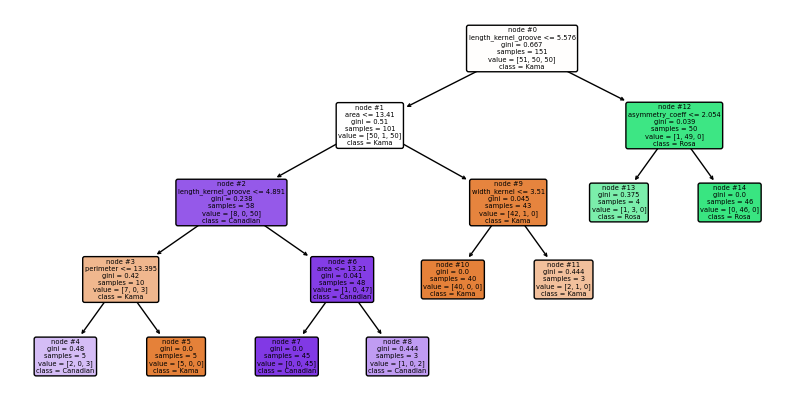

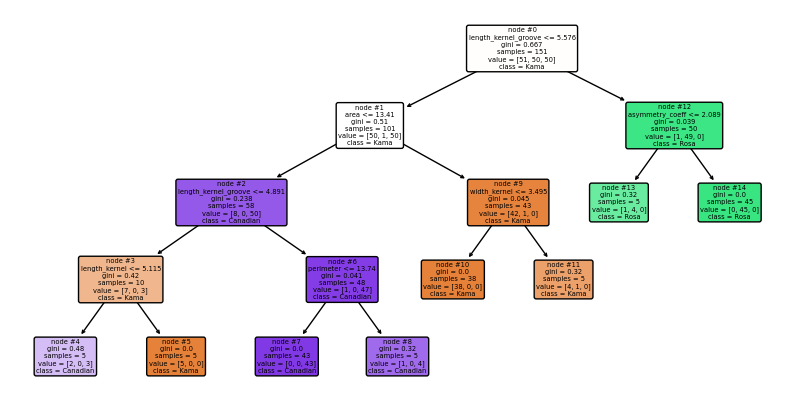

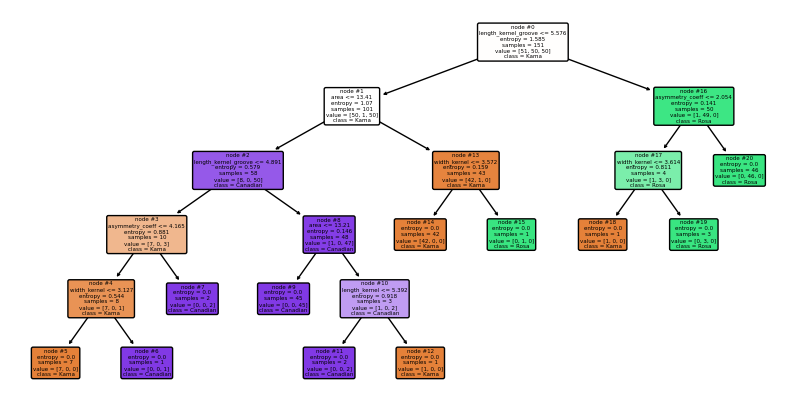

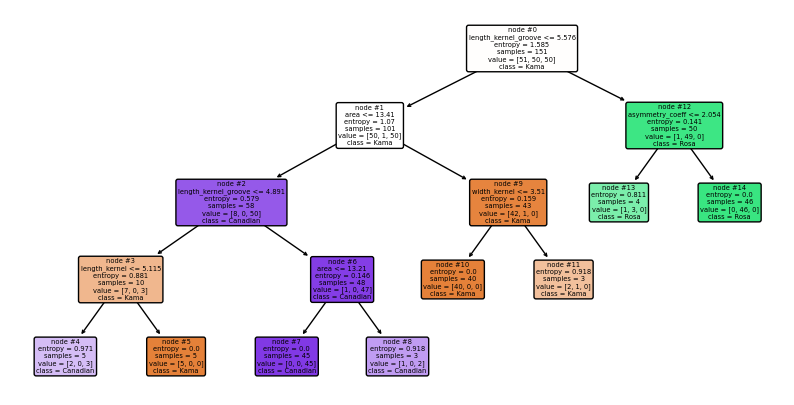

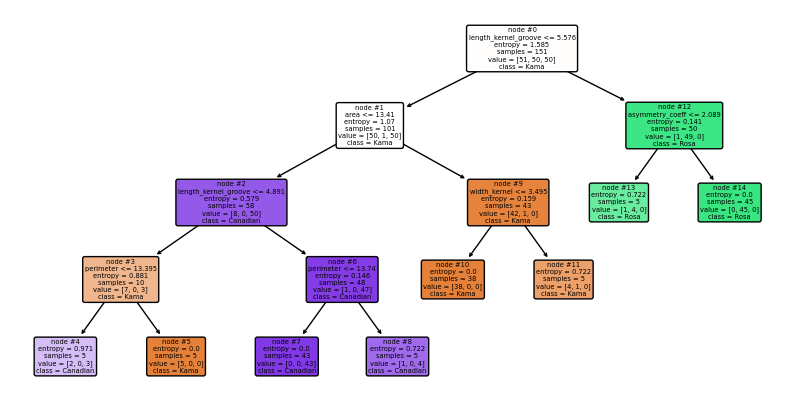

In [26]:
configs = [{'criterion': 'gini', 'min_samples_split': 2, 'min_samples_leaf': 1},
           {'criterion': 'gini', 'min_samples_split': 6, 'min_samples_leaf': 3},
           {'criterion': 'gini', 'min_samples_split': 10, 'min_samples_leaf': 5},
           {'criterion': 'entropy', 'min_samples_split': 2, 'min_samples_leaf': 1},
           {'criterion': 'entropy', 'min_samples_split': 6, 'min_samples_leaf': 3},
           {'criterion': 'entropy', 'min_samples_split': 10, 'min_samples_leaf': 5}]

for i, config in enumerate(configs):
    # Llamada al constructor del árbol de decisión con la configuración apropiada
    clasificador = DecisionTreeClassifier(criterion=config['criterion'], min_samples_split=config['min_samples_split'], min_samples_leaf=config['min_samples_leaf'])
    # Entrenamiento del árbol de decisión
    clasificador = clasificador.fit(X_train, y_train)
    # Mostramos el árbol de decisión en una figura usando el método plot_tree de la clase tree
    fig = plt.figure(figsize=(10,5))
    plot_tree(clasificador, feature_names=feature_names, class_names=class_names, filled=True, rounded=True, node_ids=True)
    # Establecemos el nombre del fichero donde guardamos la figura
    nombreFicheroSalida = 'arbol' + str(i) + '.png'
    # Guardamos la figura en un archivo png
    fig.savefig(nombreFicheroSalida)

## Evaluación

### Matriz de Confusión ###

Creamos una funcion que sirva para crear matrizes de confusion

In [27]:
def obtenerMatrizConfusion(clasificador, X, y, labels):
    predicciones = clasificador.predict(X)
    return confusion_matrix(y, predicciones, labels=labels)

Realizamos la matriz de confusion para todos los metodos con los datos de entrenamiento

In [28]:
# Matriz de confusion
# KNN con train
matrizConfusionKNN_train = obtenerMatrizConfusion(knn, X_train, y_train, labels=[1,2,3])
print("Matriz de confusión KNN con los valores de TRAIN:")
print(matrizConfusionKNN_train)

# Regresion con train
matrizConfusionLR_train = obtenerMatrizConfusion(lr, X_train, y_train, labels=[1,2,3])
print("Matriz de confusión regresion con los valores de TRAIN:")
print(matrizConfusionLR_train)

# Arbol de decision con train
matrizConfusionArbolDecision_train = obtenerMatrizConfusion(tree, X_train, y_train, labels=[1,2,3])
print("Matriz de confusión arbol de decision con los valores de TRAIN:")
print(matrizConfusionArbolDecision_train)

Matriz de confusión KNN con los valores de TRAIN:
[[44  0  7]
 [ 3 47  0]
 [ 2  0 48]]
Matriz de confusión regresion con los valores de TRAIN:
[[46  2  3]
 [ 3 47  0]
 [ 3  0 47]]
Matriz de confusión arbol de decision con los valores de TRAIN:
[[51  0  0]
 [ 0 50  0]
 [ 0  0 50]]


Realizamos la matriz de confusion para todos los metodos con los datos de test

In [29]:
# Matriz de confusion
# KNN con test
matrizConfusionKNN_test = obtenerMatrizConfusion(knn, X_test, y_test, labels=[1,2,3])
print("Matriz de confusión KNN con los valores de TEST:")
print(matrizConfusionKNN_test)

# Regresion con test
matrizConfusionRegresion_test = obtenerMatrizConfusion(lr, X_test, y_test, labels=[1,2,3])
print("Matriz de confusión regresión con los valores de TEST:")
print(matrizConfusionRegresion_test)

# Arbol de decision con test
matrizConfusionArbolDecision_test = obtenerMatrizConfusion(tree, X_test, y_test, labels=[1,2,3])
print("Matriz de confusión arbol de decisión con los valores de TEST:")
print(matrizConfusionArbolDecision_test)

Matriz de confusión KNN con los valores de TEST:
[[4 1 2]
 [0 7 0]
 [0 0 7]]
Matriz de confusión regresión con los valores de TEST:
[[5 1 1]
 [0 7 0]
 [0 0 7]]
Matriz de confusión arbol de decisión con los valores de TEST:
[[6 0 1]
 [0 7 0]
 [0 0 7]]


### Grid ###

In [30]:
def mejorEstimador(estimador, parametros, X_train, y_train):
    mejor_puntuacion = 0
    mejor_estimador = None
    mejor_parametro = {}

    # Recorro todos los estimadores buscando cual es el mejor
    for nombre, estimador in estimadores:
        # Creo el grid
        grid_search = GridSearchCV(estimator=estimador, param_grid=parametros[nombre], cv=5)
        
        # Entreno el grid
        grid_search.fit(X_train, y_train)
        
        # Muestro los mejores parametros y la mejor puntuacion
        print("Estimador: {}".format(nombre))
        print("\tMejor puntuación: {}%".format(round(grid_search.best_score_*100,2)))
        print("\tMejores parametros: {}".format(grid_search.best_params_))
        
        # Almaceno la mejor puntuacion y los mejores parametros
        if grid_search.best_score_> mejor_puntuacion:
            mejor_estimador = nombre
            mejor_puntuacion = grid_search.best_score_
            mejor_parametro = grid_search.best_params_

    # Muestro la mejor puntacion y el mejor parametro
    print("\nRESULTADO FINAL")
    print("\tMejor estimador: {}".format(mejor_estimador))
    print("\tMejor puntuación: {}%".format(round(mejor_puntuacion*100,2)))
    print("\tMejore parametros: {}".format(mejor_parametro))
    return mejor_estimador, mejor_puntuacion, mejor_parametro

# Prueba
estimadores = [
    ("KNN", KNeighborsClassifier()),
    ("Arbol decision", DecisionTreeClassifier()),
    ("Regresion logistica", LogisticRegression())
]

parametros = {
    "KNN":{
        "n_neighbors": [1,3,5,7,9],
        "weights": ["uniform", "distance"]
    },
    "Arbol decision":{
        "max_depth": [3,5,7,None],
        "criterion": ["gini","entropy"]
    },
    "Regresion logistica":{
        "solver": ["liblinear"]
    }
}

mejorEstimador(estimadores, parametros, X_train, y_train);


Estimador: KNN
	Mejor puntuación: 93.4%
	Mejores parametros: {'n_neighbors': 5, 'weights': 'distance'}
Estimador: Arbol decision
	Mejor puntuación: 93.44%
	Mejores parametros: {'criterion': 'entropy', 'max_depth': 3}
Estimador: Regresion logistica
	Mejor puntuación: 92.73%
	Mejores parametros: {'solver': 'liblinear'}

RESULTADO FINAL
	Mejor estimador: Arbol decision
	Mejor puntuación: 93.44%
	Mejore parametros: {'criterion': 'entropy', 'max_depth': 3}
